## **Load *Monod*+meK-Means and Packages**

In [13]:
import sys
sys.path.insert(0, '/home/tchari/monod/src/')

In [14]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference
from monod.analysis import *

In [15]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import scipy.stats

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import accuracy_score, classification_report

import os

import sklearn
import scanpy as sc
import anndata

import random
import glob

In [16]:
#Packages for Leiden comparison
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

import igraph as ig
import leidenalg as la

import itertools

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## **Read in data and metadata**

In [18]:
#read in adata with metadata

meta_path = "/home/tchari/metadata/"
adata = anndata.read_h5ad(meta_path+'gehring_multiplex.h5ad')

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [19]:
#Set up filepaths for Monod

remain = [[str(i)] for i in range(96) if i not in [93,83]] #Filter out 0 count conditions
all_conds = remain

loom_filepaths = ['/home/tchari/counts/gehring_nsc/loom/nsc_all.loom']*len(all_conds)

dataset_names = ['nsc_'+'_'.join(n) for n in all_conds] #To save
print('len(dataset_names): ',len(dataset_names))
print()

raw_data_locations = dataset_names
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]


n_datasets = len(loom_filepaths)

len(dataset_names):  94



In [20]:
len(all_conds)

94

## **Process Cell Barcodes**

Filter out cell barcodes with low UMI counts

Dataset nsc_0. 
	21232 barcodes in loom, 21063 pass filter. 21232 in annotations; of these, 21232 in loom and 21063 in filtered loom.
	['0']: 21 cells in annotations. 21 in loom. 21 pass filter.
	['1']: 73 cells in annotations. 73 in loom. 73 pass filter.
	['2']: 63 cells in annotations. 63 in loom. 63 pass filter.
	['3']: 114 cells in annotations. 114 in loom. 114 pass filter.
	['4']: 104 cells in annotations. 104 in loom. 104 pass filter.
	['5']: 23 cells in annotations. 23 in loom. 23 pass filter.
	['6']: 130 cells in annotations. 130 in loom. 129 pass filter.
	['7']: 76 cells in annotations. 76 in loom. 74 pass filter.
	['8']: 975 cells in annotations. 975 in loom. 972 pass filter.
	['9']: 17 cells in annotations. 17 in loom. 14 pass filter.
	['10']: 6 cells in annotations. 6 in loom. 6 pass filter.
	['11']: 130 cells in annotations. 130 in loom. 130 pass filter.
	['12']: 71 cells in annotations. 71 in loom. 71 pass filter.
	['13']: 68 cells in annotations. 68 in loom. 68 pass filt

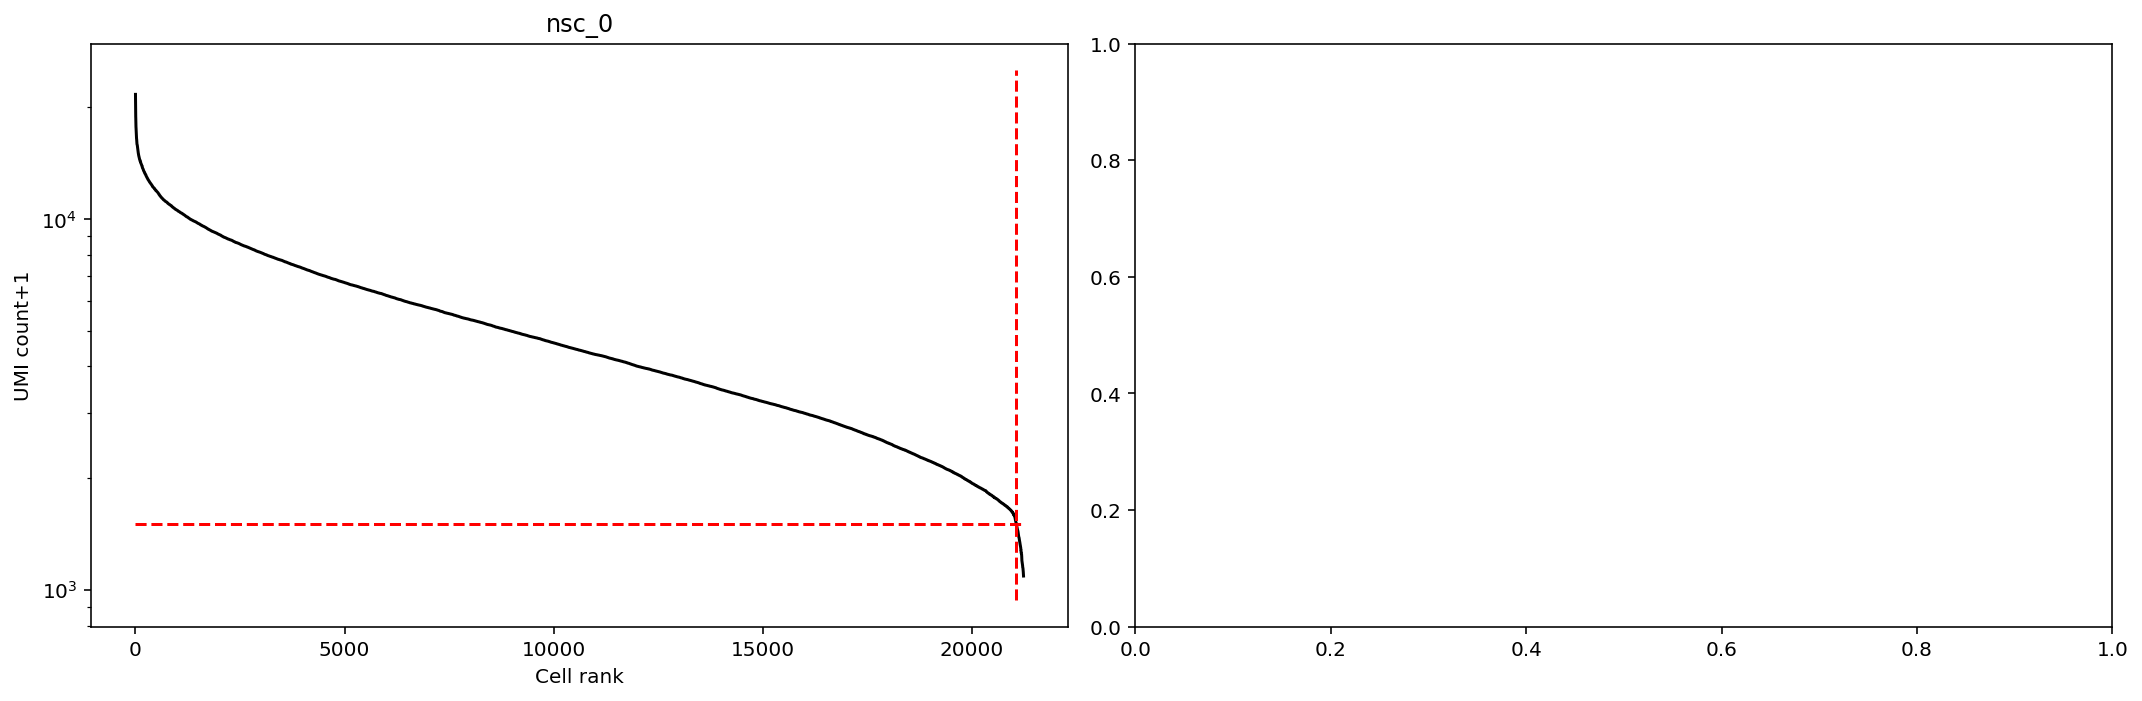

In [21]:
cf = []
thr_lb = [1.5e3]*2

fig1,ax1 = plt.subplots(1,2,figsize=(15,5))

for k in range(1):
    filename = loom_filepaths[k]
    dataset_name = raw_data_locations[k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = len(adata.obs_names)
        annot_bcs_in_loom = adata.obs_names.isin(bcs).sum()
        annot_bcs_in_filt_loom = adata.obs_names.isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        #if k==0:
        for subcluster in all_conds:
            annot_bcs = adata[(adata.obs['assignments'].isin(subcluster))].obs_names
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')



    ax1[k].set_title(dataset_name)
    
!mkdir ./figs    
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_all_gehring.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

## **Test meK-Means on Conditions**

Are there novel perturbed populations of cells within conditions?

In [22]:
#Get full count matrices and barcodes
ds = lp.connect('/home/tchari/counts/gehring_nsc/loom/nsc_all.loom')
U = ds.layers['unspliced'][:].T
S = ds.layers['spliced'][:].T
bars = ds.ca['barcode']
g_names = ds.ra['gene_name']
ds.close()

**Run meK-Means**

In [23]:
#Threshold for filtering genes based on expression patterns
def nb_thresh(U,S,var_t = 1.5,u_min =0.02,s_min =0.02):
    '''
    Take in U,S matrices, and find genes that meet var/mean thresh
    U,S are cellxgene
    '''
    var_threshold = var_t
    U_mean = U.mean(0)
    S_mean = S.mean(0)
    U_var = U.var(0)
    S_var = S.var(0)

    #if l == '/home/tchari/counts/allen_bivi/loom/processed_allen_B02H01A02_raw.loom':
    u_min = u_min
    s_min =  s_min


    fitted_idx = (U_mean > u_min) & (S_mean > s_min) \
    & (((U_var-U_mean)/(U_mean**2)) > var_threshold)\
    & (((S_var-S_mean)/(S_mean**2)) > var_threshold)\
    & (np.abs(np.log(S_mean/U_mean)) < 4) 
    #((U_mean/S_mean) > 1.0) #labeled mRNA (new synth) is mainly intronic counts
    
    #(np.abs(np.log(S_mean/U_mean)) < 4) 
    
    
    return fitted_idx

In [24]:
def check_at_bounds(phys_params,thr=0.01,phys_lb=[-2.0, -1.8, -1.8 ],phys_ub=[4.2, 2.5, 2.5]):
    #Check for genes where parameter fits are close to boundary of grid
    x = np.any(np.logical_or(
        np.array(phys_lb)+thr > phys_params,
        np.array(phys_ub)-thr < phys_params) ,1)
    return x

In [25]:
def get_assigns(sr):
    '''
    Get cell cluster assignments
    '''
    cats = np.array([None]*len(sr[0].filt))
    for r in sr:
        cats[r.filt] = r.assigns
    return cats

In [26]:
def vis_metrics(results,title,ks,figsize=(18, 5),s=50,fname=None):
    '''
    Visualize -Q function and KLD over epochs, and -AIC for final model inference

    results: list of len num_ks, of lists of SearchResults objs per K tested (e.g. [[SearchResults],[SearchResults,SearchResults]] for K=1&2)
    title: title string for leftmost, plot
    ks: list of ks tested (e.g. [1,2])
    figsize: tuple for size of figure
    s: size of dots in scatterplot
    save_file: string, output file to save image

  '''

    num_ks = len(results)
    sets = []
    qs = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()

    aic = []
    fin_k = []
    kls = []

    epoch = len(results[0][0].all_qs.flatten())
    epos = list(range(1,epoch+1))*num_ks

    for i in range(num_ks):

        qs += list(-1*results[i][0].all_qs.flatten())
        sets += [ks[i]]*epoch
        aic += [results[i][0].aic[0]]
        fin_k += [len(results[i])]


        concat_klds = []
        ks_used = []
        for r in results[i]:
            concat_klds += [r.all_klds[0,:,:]]
            ks_used += [r.assigns]

        concat_klds = np.array(concat_klds)
        concat_klds = concat_klds.reshape((concat_klds.shape[1], concat_klds.shape[2],concat_klds.shape[0]))

        kls += list(np.mean(np.sum(concat_klds[:,:,:],axis=1),axis=1)) #Sum of klds across k clusters


    res['Q'] = qs
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = ['k='+str(j) for j in sets]

    aics['AIC'] = aic
    aics['k'] = [str(j) for j in ks ]
    aics['fin_k'] = fin_k

    #Plot Q function over epochs
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)

    sns.lineplot(data=res,x='epoch',y='Q',hue='setting',
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    g1=sns.scatterplot(data=res,x='epoch',y='Q',hue='setting',
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('-Q')
    ax[0].legend(
          title='Set K')
    ax[0].set_title(title)
    sns.move_legend(g1, "upper left", bbox_to_anchor=(1, 1))


    #Plot klds over epochs
    g2=sns.lineplot(data=res,x='epoch',y='KLD',hue='setting',
                    ax=ax[1],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='KLD',hue='setting',
                    ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('KLD')
    ax[1].legend(
          title='Set K')
    sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1))



    #Plot aics
    g3=sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final Assigned k')
    ax[2].set_ylabel('-AIC')
    ax[2].legend(
          title='Set K')
    sns.move_legend(g3, "upper left", bbox_to_anchor=(1, 1))


    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)


In [27]:
#Set up files for meK-Means runs and different Ks
conds_forinf = [18,19,20,21,22,23,42,43,44,45,46,47]
Ks = [3,5]
cfs = [cf[i] for i in conds_forinf]


loom_filepaths = ['/home/tchari/counts/gehring_nsc/loom/nsc_all.loom']*len(Ks)

#sub_dataset_names = ['meK_gehr_'+str(i)+'_k'+str(j) for i,j in zip(conds_forinf,sub_ks)]



In [28]:
epochs = 10

In [30]:
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-7.888888888888889, -0.6999999999999997] 
samp_ub = [-7.888888888888889, -0.6999999999999997]
gridsize = [1,1]


In [33]:
result_strings = []
data_names = []

for c in range(len(conds_forinf)):
    
    S_sub = S[cfs[c],:]
    
    #Make anndata with conditions and get most variable genes
    adata = anndata.AnnData(X=S_sub)
    adata.layers["counts"] = adata.X.copy()  # preserve counts
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    g_filt_hvg = adata.var.highly_variable
    
    #Filter for overdispersed *and* enough U/S counts for clustering
    g_filt = nb_thresh(U,S,var_t = 1.5,u_min =0.02,s_min =0.02)
    #g_filt_lit = pd.Categorical(g_names).isin(lit_genes)


    final_filt =  (g_filt_hvg & g_filt) #Filter hvgs + add lit genes, g_filt_lit  & g_filt)
    final_names = g_names[final_filt]


    print('Cond: ',str(conds_forinf[c]),' with ',str(np.sum(final_filt)),' genes')

    dataset_names = ['meK_gehr_'+str(i)+'_k'+str(j) for i,j in zip([conds_forinf[c]]*len(Ks),Ks)]
    data_names += dataset_names
    
    dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                                 transcriptome_filepath, \
                                                 dataset_names, \
                                                 attribute_names=attribute_names,\
                                                 batch_location='./fits',meta='meK_gehring',batch_id=1,\
                                                 n_genes=len(final_names),\
                                                 exp_filter_threshold=None,cf=[cfs[c]]*len(Ks),
                                                 viz=False,
                                                 genes_to_fit=final_names)
    
    
    for i in range(len(Ks)): #Here only running meK-Means for K=5,10 not K=1

        #Define model with bursty transcription and Poisson molecule capture/sampling
        fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

        #Set up mminference parameters
        inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                    dataset_strings[i],fitmodel,k=Ks[i],epochs=epochs,use_lengths = True,
                    gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})

        #Read in loom file with filtered barcodes
        search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, 
                    dataset_names[i],
                    dataset_strings[i], dir_string, viz=False, 
                    dataset_attr_names=attribute_names,
                    cf=cfs[c])

        #Run inference(fit_all_grid_points()) and Save result file strings
        full_result_string = inference_parameters.fit_all_grid_points(30,search_data) 

        result_strings.append(full_result_string)

    

/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  if __name__ == '__main__':
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


Cond:  18  with  63  genes


/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.68it/s]


mstep self.weights:  [0.27166213 0.40158903 0.32674884]
Q Function:  -35790.67849886237



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.32it/s]


mstep self.weights:  [0.37275822 0.61447931 0.01276247]
Q Function:  -36848.577385386605



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.97it/s]


mstep self.weights:  [3.38889521e-01 6.61110479e-01 9.59054809e-10]
Q Function:  -35946.220248621175



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.96it/s]


mstep self.weights:  [3.10685164e-01 6.89314836e-01 8.09716602e-10]
Q Function:  -35891.65094998986



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.01it/s]


mstep self.weights:  [2.86220594e-01 7.13779405e-01 8.09716598e-10]
Q Function:  -35860.73053364799



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.75it/s]


mstep self.weights:  [2.76522670e-01 7.23477329e-01 8.09716598e-10]
Q Function:  -35791.356296900674



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.93it/s]


mstep self.weights:  [2.78261497e-01 7.21738503e-01 8.09716598e-10]
Q Function:  -35744.96723166736



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.89it/s]


mstep self.weights:  [2.74789900e-01 7.25210099e-01 8.09716599e-10]
Q Function:  -35776.99484266333



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.88it/s]


mstep self.weights:  [2.71943312e-01 7.28056687e-01 8.09716598e-10]
Q Function:  -35762.80806686735



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.88it/s]


mstep self.weights:  [2.71614711e-01 7.28385288e-01 8.09716598e-10]
Q Function:  -35761.24006964026



/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


mstep self.weights:  [0.22448089 0.1964107  0.20930946 0.21143885 0.15836011]
Q Function:  -36341.67551038333



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


mstep self.weights:  [0.32111871 0.08610805 0.18732493 0.33847285 0.06697544]
Q Function:  -37768.69712448228



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.45it/s]


mstep self.weights:  [4.55790200e-01 8.39902034e-03 1.47309365e-03 5.34320904e-01
 1.67828045e-05]
Q Function:  -37219.377536910004



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.70it/s]


mstep self.weights:  [4.38859684e-01 8.09716596e-10 8.09778312e-10 5.61140313e-01
 9.26622898e-10]
Q Function:  -36163.219742783665



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.92it/s]


mstep self.weights:  [4.17957841e-01 8.09716596e-10 8.09716596e-10 5.82042157e-01
 8.09724198e-10]
Q Function:  -36084.86705310218



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.75it/s]


mstep self.weights:  [4.15550807e-01 8.09716596e-10 8.09716596e-10 5.84449190e-01
 8.09720174e-10]
Q Function:  -35815.82948947361



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.93it/s]


mstep self.weights:  [6.24169469e-01 8.09716596e-10 8.09716596e-10 3.75830529e-01
 8.09729802e-10]
Q Function:  -37413.076395194235



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.85it/s]


mstep self.weights:  [9.95347154e-01 8.09716596e-10 8.09717058e-10 4.65284309e-03
 8.09900796e-10]
Q Function:  -37011.64485509106



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


mstep self.weights:  [9.99999997e-01 8.09716596e-10 8.09716596e-10 8.11196427e-10
 8.09718729e-10]
Q Function:  -35470.889390358134



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.00it/s]


mstep self.weights:  [9.99999997e-01 8.09716596e-10 8.09716596e-10 8.09716596e-10
 8.09718833e-10]
Q Function:  -35463.14085239135



/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  if __name__ == '__main__':
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


Cond:  19  with  72  genes


/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.99it/s]


mstep self.weights:  [0.05651391 0.76012924 0.18335686]
Q Function:  -11667.541623124343



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.40it/s]


mstep self.weights:  [3.84612774e-08 9.74241270e-01 2.57586919e-02]
Q Function:  -11565.362312723722



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.54it/s]


mstep self.weights:  [2.87356319e-09 9.97127249e-01 2.87274850e-03]
Q Function:  -11222.671525930342



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.53it/s]


mstep self.weights:  [2.87356319e-09 9.97126470e-01 2.87352695e-03]
Q Function:  -11208.43394749146



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.55it/s]


mstep self.weights:  [2.87356319e-09 9.97126470e-01 2.87352696e-03]
Q Function:  -11208.433947413481



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.54it/s]


mstep self.weights:  [2.87356319e-09 9.97126470e-01 2.87352696e-03]
Q Function:  -11208.43394741348



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.54it/s]


mstep self.weights:  [2.87356319e-09 9.97126470e-01 2.87352696e-03]
Q Function:  -11208.43394741348



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.55it/s]


mstep self.weights:  [2.87356319e-09 9.97126470e-01 2.87352696e-03]
Q Function:  -11208.43394741348



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.49it/s]


mstep self.weights:  [2.87356319e-09 9.97126470e-01 2.87352696e-03]
Q Function:  -11208.43394741348



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.54it/s]


mstep self.weights:  [2.87356319e-09 9.97126470e-01 2.87352696e-03]
Q Function:  -11208.43394741348



/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.21it/s]


mstep self.weights:  [0.37888525 0.09791424 0.10103826 0.07394994 0.34821232]
Q Function:  -12874.04851739943



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.18it/s]


mstep self.weights:  [1.96293870e-01 2.45021231e-06 7.46946794e-04 2.87522436e-03
 8.00081509e-01]
Q Function:  -11782.428654075646



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.11it/s]


mstep self.weights:  [1.17258093e-02 2.87883368e-09 2.87653484e-09 2.87353437e-03
 9.85400651e-01]
Q Function:  -11309.49023371912



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.52it/s]


mstep self.weights:  [2.87364168e-09 2.87356596e-09 2.87356319e-09 2.87275015e-03
 9.97127241e-01]
Q Function:  -11241.692455476521



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.51it/s]


mstep self.weights:  [2.87356318e-09 2.87356595e-09 2.87356319e-09 2.87137478e-03
 9.97128617e-01]
Q Function:  -11212.465606442891



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.56it/s]


mstep self.weights:  [2.87356318e-09 2.87356595e-09 2.87356319e-09 2.87137373e-03
 9.97128618e-01]
Q Function:  -11212.465608954695



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.51it/s]


mstep self.weights:  [2.87356318e-09 2.87356595e-09 2.87356319e-09 2.87137373e-03
 9.97128618e-01]
Q Function:  -11212.465608956707



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.45it/s]


mstep self.weights:  [2.87356318e-09 2.87356595e-09 2.87356319e-09 2.87137373e-03
 9.97128618e-01]
Q Function:  -11212.465608956707



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.45it/s]


mstep self.weights:  [2.87356318e-09 2.87356595e-09 2.87356319e-09 2.87137373e-03
 9.97128618e-01]
Q Function:  -11212.465608956707



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.56it/s]


mstep self.weights:  [2.87356318e-09 2.87356595e-09 2.87356319e-09 2.87137373e-03
 9.97128618e-01]
Q Function:  -11212.465608956707



/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  if __name__ == '__main__':
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


Cond:  20  with  55  genes


/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.62it/s]


mstep self.weights:  [0.05665576 0.57615468 0.36718956]
Q Function:  -14105.183869386758



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.27it/s]


mstep self.weights:  [8.93505912e-05 7.04904912e-01 2.95005737e-01]
Q Function:  -13793.848994699438



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.13it/s]


mstep self.weights:  [2.94132891e-09 7.63171276e-01 2.36828721e-01]
Q Function:  -13571.485618632643



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.18it/s]


mstep self.weights:  [1.89319674e-09 8.78566247e-01 1.21433751e-01]
Q Function:  -13734.778333651087



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.94it/s]


mstep self.weights:  [1.89049319e-09 9.17286279e-01 8.27137189e-02]
Q Function:  -13561.465821984306



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.05it/s]


mstep self.weights:  [1.89037940e-09 9.16455639e-01 8.35443588e-02]
Q Function:  -13478.189701399537



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.98it/s]


mstep self.weights:  [1.89039078e-09 9.29465414e-01 7.05345845e-02]
Q Function:  -13446.023244338745



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.98it/s]


mstep self.weights:  [1.89037723e-09 9.40908328e-01 5.90916701e-02]
Q Function:  -13542.363858224335



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.98it/s]


mstep self.weights:  [1.89038014e-09 9.46005121e-01 5.39948770e-02]
Q Function:  -13485.929097226399



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.99it/s]


mstep self.weights:  [1.89038374e-09 9.67747486e-01 3.22525116e-02]
Q Function:  -13590.97854705316



/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.81it/s]


mstep self.weights:  [0.47145848 0.16424685 0.01219008 0.0319876  0.32011698]
Q Function:  -14151.985747849269



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.89it/s]


mstep self.weights:  [6.22825598e-01 7.03649053e-02 2.24743223e-09 4.15309062e-07
 3.06809079e-01]
Q Function:  -13763.699080102797



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.25it/s]


mstep self.weights:  [7.11285773e-01 8.71180465e-06 1.89035916e-09 1.89044555e-09
 2.88705511e-01]
Q Function:  -13522.684177594856



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.16it/s]


mstep self.weights:  [8.07384679e-01 2.77287826e-09 1.89035916e-09 1.89035979e-09
 1.92615315e-01]
Q Function:  -13541.859058074311



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.27it/s]


mstep self.weights:  [8.39517100e-01 1.89090319e-09 1.89035916e-09 1.89036724e-09
 1.60482894e-01]
Q Function:  -13430.008269258717



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.22it/s]


mstep self.weights:  [8.49111414e-01 1.89037228e-09 1.89035916e-09 1.89035964e-09
 1.50888581e-01]
Q Function:  -13375.960119456468



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.11it/s]


mstep self.weights:  [9.28874529e-01 1.89041649e-09 1.89035934e-09 1.89035964e-09
 7.11254655e-02]
Q Function:  -13528.123681784884



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.97it/s]


mstep self.weights:  [9.59284392e-01 1.89097100e-09 1.89035944e-09 1.89036611e-09
 4.07156026e-02]
Q Function:  -13565.224864373675



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.05it/s]


mstep self.weights:  [9.78030538e-01 1.89107344e-09 1.89035915e-09 1.89036464e-09
 2.19694563e-02]
Q Function:  -13459.496022769847



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


mstep self.weights:  [9.99998050e-01 1.89153300e-09 1.89036020e-09 1.89036585e-09
 1.94402770e-06]
Q Function:  -13518.57133732144



/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  if __name__ == '__main__':
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


Cond:  21  with  66  genes


/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s]


mstep self.weights:  [0.25191046 0.36032392 0.38776563]
Q Function:  -48923.93231386412



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s]


mstep self.weights:  [0.05842352 0.45117848 0.49039801]
Q Function:  -47382.89135924557



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.37it/s]


mstep self.weights:  [0.01535335 0.48853976 0.49610688]
Q Function:  -46885.37092840565



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.74it/s]


mstep self.weights:  [8.51089617e-10 5.20714503e-01 4.79285497e-01]
Q Function:  -46756.99539849587



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.77it/s]


mstep self.weights:  [7.08717226e-10 5.10836007e-01 4.89163992e-01]
Q Function:  -46831.561665250396



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.80it/s]


mstep self.weights:  [7.08717222e-10 5.09334438e-01 4.90665561e-01]
Q Function:  -46821.244234130376



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.81it/s]


mstep self.weights:  [7.08717223e-10 5.08338268e-01 4.91661732e-01]
Q Function:  -46836.44155997591



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.79it/s]


mstep self.weights:  [7.08717222e-10 4.99399458e-01 5.00600541e-01]
Q Function:  -46827.05861763113



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.74it/s]


mstep self.weights:  [7.08717223e-10 4.88917082e-01 5.11082917e-01]
Q Function:  -46894.76848704366



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.78it/s]


mstep self.weights:  [7.08717222e-10 4.87778292e-01 5.12221708e-01]
Q Function:  -46843.00394190017



/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


mstep self.weights:  [0.21572485 0.17600125 0.19749615 0.20787356 0.20290419]
Q Function:  -47784.902408588765



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


mstep self.weights:  [0.10373335 0.18501908 0.28038446 0.26024473 0.17061838]
Q Function:  -48134.878124773124



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


mstep self.weights:  [0.05050865 0.16297305 0.20783352 0.34468556 0.23399923]
Q Function:  -47838.47520460411



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.21it/s]


mstep self.weights:  [0.00577176 0.28291496 0.02632394 0.33095561 0.35403373]
Q Function:  -49460.3274134759



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.57it/s]


mstep self.weights:  [1.05538924e-06 2.35238212e-01 7.08889725e-10 3.68013022e-01
 3.96747710e-01]
Q Function:  -47069.375360718805



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.66it/s]


mstep self.weights:  [7.18268448e-10 1.90124364e-01 7.08717219e-10 3.92690008e-01
 4.17185627e-01]
Q Function:  -46803.70318866991



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.61it/s]


mstep self.weights:  [7.08719161e-10 1.70808709e-01 7.08717219e-10 4.12336386e-01
 4.16854903e-01]
Q Function:  -46690.07799411137



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.60it/s]


mstep self.weights:  [7.08722166e-10 1.53837036e-01 7.08717219e-10 4.26656147e-01
 4.19506815e-01]
Q Function:  -46648.68556159423



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.29it/s]


mstep self.weights:  [7.08720093e-10 1.52363728e-02 7.08717219e-10 4.96674069e-01
 4.88089556e-01]
Q Function:  -46925.0094407454



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.62it/s]


mstep self.weights:  [7.70144862e-10 4.81612786e-04 7.08717219e-10 4.95208046e-01
 5.04310339e-01]
Q Function:  -46593.517398507705



/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  if __name__ == '__main__':
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


Cond:  22  with  65  genes


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.37it/s]


mstep self.weights:  [0.13662465 0.67050497 0.19287037]
Q Function:  -7454.161497937098



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.72it/s]


mstep self.weights:  [7.46700566e-05 9.79364665e-01 2.05606647e-02]
Q Function:  -6708.655752240621



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


mstep self.weights:  [9.22560403e-09 9.99999986e-01 5.10323921e-09]
Q Function:  -6540.453458803824



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


mstep self.weights:  [5.10264997e-09 9.99999990e-01 5.10204074e-09]
Q Function:  -6539.234579614653



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


mstep self.weights:  [5.10237770e-09 9.99999990e-01 5.10204074e-09]
Q Function:  -6539.234578805106



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


mstep self.weights:  [5.10237769e-09 9.99999990e-01 5.10204074e-09]
Q Function:  -6539.234578805053



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


mstep self.weights:  [5.10237769e-09 9.99999990e-01 5.10204074e-09]
Q Function:  -6539.234578805053



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


mstep self.weights:  [5.10237769e-09 9.99999990e-01 5.10204074e-09]
Q Function:  -6539.234578805053



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


mstep self.weights:  [5.10237769e-09 9.99999990e-01 5.10204074e-09]
Q Function:  -6539.234578805053



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


mstep self.weights:  [5.10237769e-09 9.99999990e-01 5.10204074e-09]
Q Function:  -6539.234578805053



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


mstep self.weights:  [1.20026654e-04 6.13076185e-02 6.14641310e-02 7.91662234e-02
 7.97942000e-01]
Q Function:  -7759.273538337577



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.49it/s]


mstep self.weights:  [5.14068443e-09 5.47190081e-09 3.27877908e-06 9.75187041e-03
 9.90244840e-01]
Q Function:  -7158.035283522531



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


mstep self.weights:  [5.10204071e-09 5.10204069e-09 5.10204616e-09 5.38092630e-09
 9.99999979e-01]
Q Function:  -6550.842957078086



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


mstep self.weights:  [5.10204071e-09 5.10204069e-09 5.10204069e-09 5.10204071e-09
 9.99999980e-01]
Q Function:  -6545.845422808165



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


mstep self.weights:  [5.10204071e-09 5.10204069e-09 5.10204069e-09 5.10204071e-09
 9.99999980e-01]
Q Function:  -6545.845422753502



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


mstep self.weights:  [5.10204071e-09 5.10204069e-09 5.10204069e-09 5.10204071e-09
 9.99999980e-01]
Q Function:  -6545.845422753502



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


mstep self.weights:  [5.10204071e-09 5.10204069e-09 5.10204069e-09 5.10204071e-09
 9.99999980e-01]
Q Function:  -6545.845422753502



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


mstep self.weights:  [5.10204071e-09 5.10204069e-09 5.10204069e-09 5.10204071e-09
 9.99999980e-01]
Q Function:  -6545.845422753502



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


mstep self.weights:  [5.10204071e-09 5.10204069e-09 5.10204069e-09 5.10204071e-09
 9.99999980e-01]
Q Function:  -6545.845422753502



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


mstep self.weights:  [5.10204071e-09 5.10204069e-09 5.10204069e-09 5.10204071e-09
 9.99999980e-01]
Q Function:  -6545.845422753502



/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  if __name__ == '__main__':
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


Cond:  23  with  62  genes


/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s]


mstep self.weights:  [0.30683864 0.60295995 0.09020141]
Q Function:  -6937.383512348304



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.67it/s]


mstep self.weights:  [0.13665967 0.86033499 0.00300534]
Q Function:  -6843.3985775280835



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.74it/s]


mstep self.weights:  [1.60030463e-01 8.39827251e-01 1.42285862e-04]
Q Function:  -7872.350560066848



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.65it/s]


mstep self.weights:  [1.46619975e-02 9.85325062e-01 1.29405585e-05]
Q Function:  -8085.832798916557



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


mstep self.weights:  [1.09584749e-03 9.98904142e-01 1.00293532e-08]
Q Function:  -6528.6566278915425



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


mstep self.weights:  [1.89370621e-06 9.99998103e-01 3.21758456e-09]
Q Function:  -6492.697798182997



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


mstep self.weights:  [6.48064363e-09 9.99999990e-01 3.21612323e-09]
Q Function:  -6492.35298870907



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


mstep self.weights:  [3.22660825e-09 9.99999994e-01 3.21612291e-09]
Q Function:  -6492.35238776319



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


mstep self.weights:  [3.22099750e-09 9.99999994e-01 3.21612291e-09]
Q Function:  -6492.352386718282



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


mstep self.weights:  [3.22098783e-09 9.99999994e-01 3.21612291e-09]
Q Function:  -6492.352386716479



/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


mstep self.weights:  [0.19821525 0.03144565 0.07512398 0.62877592 0.06643921]
Q Function:  -9616.603237334595



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.46it/s]


mstep self.weights:  [7.00726618e-03 6.31238416e-03 7.40487619e-04 9.81901296e-01
 4.03856619e-03]
Q Function:  -8526.401347559604



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.96it/s]


mstep self.weights:  [1.64176927e-03 3.21724315e-09 3.25798988e-09 9.98358221e-01
 3.21768919e-09]
Q Function:  -6497.1612885905



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


mstep self.weights:  [3.21543405e-09 3.21543403e-09 3.21543616e-09 9.99999987e-01
 3.21543403e-09]
Q Function:  -6492.462612781959



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


mstep self.weights:  [3.21543403e-09 3.21543403e-09 3.21543612e-09 9.99999987e-01
 3.21543403e-09]
Q Function:  -6492.35238867471



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


mstep self.weights:  [3.21543403e-09 3.21543403e-09 3.21543612e-09 9.99999987e-01
 3.21543403e-09]
Q Function:  -6492.35238867471



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


mstep self.weights:  [3.21543403e-09 3.21543403e-09 3.21543612e-09 9.99999987e-01
 3.21543403e-09]
Q Function:  -6492.35238867471



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


mstep self.weights:  [3.21543403e-09 3.21543403e-09 3.21543612e-09 9.99999987e-01
 3.21543403e-09]
Q Function:  -6492.35238867471



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


mstep self.weights:  [3.21543403e-09 3.21543403e-09 3.21543612e-09 9.99999987e-01
 3.21543403e-09]
Q Function:  -6492.35238867471



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


mstep self.weights:  [3.21543403e-09 3.21543403e-09 3.21543612e-09 9.99999987e-01
 3.21543403e-09]
Q Function:  -6492.35238867471



/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  if __name__ == '__main__':
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


Cond:  42  with  37  genes


/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s]


mstep self.weights:  [0.28013945 0.33584449 0.38401606]
Q Function:  -72641.56708372114



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.41it/s]


mstep self.weights:  [0.29931678 0.52696499 0.17371822]
Q Function:  -74750.5692844667



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.86it/s]


mstep self.weights:  [0.29347462 0.69383087 0.01269451]
Q Function:  -72453.74832281598



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.31it/s]


mstep self.weights:  [2.83088785e-01 7.16397940e-01 5.13275336e-04]
Q Function:  -71278.99429923791



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.48it/s]


mstep self.weights:  [2.90301052e-01 7.09697925e-01 1.02334612e-06]
Q Function:  -71230.58279459907



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.62it/s]


mstep self.weights:  [2.85930677e-01 7.14069321e-01 2.11278624e-09]
Q Function:  -71606.5878973597



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.65it/s]


mstep self.weights:  [2.82743899e-01 7.17256101e-01 2.68719399e-10]
Q Function:  -71338.40101130295



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.58it/s]


mstep self.weights:  [2.84780755e-01 7.15219245e-01 2.65645085e-10]
Q Function:  -71672.16218939368



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.60it/s]


mstep self.weights:  [2.95444154e-01 7.04555846e-01 2.65644671e-10]
Q Function:  -71172.97005244094



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.56it/s]


mstep self.weights:  [2.92099552e-01 7.07900448e-01 2.65621819e-10]
Q Function:  -71709.81833804857



/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


mstep self.weights:  [0.1789696  0.2019262  0.22044807 0.19365325 0.20500287]
Q Function:  -74546.66622820085



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


mstep self.weights:  [0.06580633 0.33393228 0.13136367 0.16371167 0.30518605]
Q Function:  -77348.06971473015



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.03it/s]


mstep self.weights:  [0.00204841 0.31814705 0.10947495 0.25328652 0.31704307]
Q Function:  -74091.82375576565



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.83it/s]


mstep self.weights:  [2.51881076e-08 2.97942511e-01 7.21700549e-02 3.15143221e-01
 3.14744188e-01]
Q Function:  -72607.86356030239



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.28it/s]


mstep self.weights:  [2.65577954e-10 4.42270362e-01 6.94235417e-02 2.95139594e-01
 1.93166502e-01]
Q Function:  -79077.72345607205



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.77it/s]


mstep self.weights:  [2.65255699e-10 2.30005179e-01 1.15568513e-02 4.19820721e-01
 3.38617248e-01]
Q Function:  -76232.59522950114



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.12it/s]


mstep self.weights:  [2.65259712e-10 3.55271412e-01 7.56506206e-03 5.37544937e-01
 9.96185884e-02]
Q Function:  -73819.49002080933



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.54it/s]


mstep self.weights:  [2.65256560e-10 3.98860378e-01 7.08828722e-04 5.95021566e-01
 5.40922643e-03]
Q Function:  -71909.37853404076



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.69it/s]


mstep self.weights:  [2.65255171e-10 3.84023689e-01 3.35418912e-06 6.15972956e-01
 3.29863219e-10]
Q Function:  -71462.75493248035



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.01it/s]


mstep self.weights:  [2.65254867e-10 3.82550764e-01 1.79339865e-08 6.17449217e-01
 2.65251989e-10]
Q Function:  -71476.79790808416



/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  if __name__ == '__main__':
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


Cond:  43  with  70  genes


/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s]


mstep self.weights:  [0.30718254 0.25798231 0.43483515]
Q Function:  -20079.572501885392



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]


mstep self.weights:  [0.27611996 0.2525105  0.47136954]
Q Function:  -19930.529987235743



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s]


mstep self.weights:  [0.30033966 0.12705368 0.57260666]
Q Function:  -20096.216382962273



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]


mstep self.weights:  [0.3185593  0.10789451 0.5735462 ]
Q Function:  -19948.453507728722



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.36it/s]


mstep self.weights:  [0.33796321 0.08138514 0.58065165]
Q Function:  -19740.953531952586



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.08it/s]


mstep self.weights:  [0.40487384 0.01319131 0.58193486]
Q Function:  -20018.016779124864



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.67it/s]


mstep self.weights:  [3.89968051e-01 4.19990061e-05 6.09989950e-01]
Q Function:  -19842.1012063846



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.70it/s]


mstep self.weights:  [4.30952897e-01 2.83462663e-07 5.69046819e-01]
Q Function:  -19665.22531521028



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.65it/s]


mstep self.weights:  [4.21755945e-01 2.66588812e-09 5.78244053e-01]
Q Function:  -19798.511003773645



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.65it/s]


mstep self.weights:  [4.28126214e-01 1.65662360e-09 5.71873784e-01]
Q Function:  -19876.585811814206



/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.23it/s]


mstep self.weights:  [0.27197184 0.02195021 0.42992424 0.05722144 0.21893226]
Q Function:  -20395.28989025287



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.23it/s]


mstep self.weights:  [3.46060311e-01 3.21764660e-05 6.04341172e-01 1.41997100e-04
 4.94243435e-02]
Q Function:  -20368.533591519063



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.67it/s]


mstep self.weights:  [3.86812507e-01 1.64753279e-09 6.13003977e-01 2.82046569e-08
 1.83486267e-04]
Q Function:  -19760.62264755334



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.67it/s]


mstep self.weights:  [2.73345140e-01 1.64744653e-09 7.26654401e-01 1.65410627e-09
 4.55506613e-07]
Q Function:  -20300.37329082261



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.69it/s]


mstep self.weights:  [1.99872626e-01 1.64744645e-09 8.00127369e-01 1.64770881e-09
 2.07073193e-09]
Q Function:  -19949.962823521208



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.63it/s]


mstep self.weights:  [1.07634935e-01 1.64744645e-09 8.92365060e-01 1.64763007e-09
 1.64775309e-09]
Q Function:  -19911.66936088694



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.64it/s]


mstep self.weights:  [1.28568092e-01 1.64744644e-09 8.71431903e-01 1.64754826e-09
 1.64762818e-09]
Q Function:  -19630.261336785195



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.67it/s]


mstep self.weights:  [1.11176997e-01 1.64744644e-09 8.88822998e-01 1.64758910e-09
 1.64762014e-09]
Q Function:  -19682.98589655393



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.55it/s]


mstep self.weights:  [4.26550333e-02 1.64744650e-09 9.57344962e-01 1.64756522e-09
 1.64758936e-09]
Q Function:  -19975.363253600794



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.50it/s]


mstep self.weights:  [6.98532204e-03 1.64745839e-09 9.93014673e-01 1.64781886e-09
 1.64751106e-09]
Q Function:  -19900.700213653



/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  if __name__ == '__main__':
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


Cond:  44  with  75  genes


/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]


mstep self.weights:  [4.25273588e-04 1.99628530e-02 9.79611873e-01]
Q Function:  -5984.443261044121



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.45it/s]


mstep self.weights:  [5.29102880e-09 5.28697148e-03 9.94713023e-01]
Q Function:  -4750.110172134246



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.45it/s]


mstep self.weights:  [5.29100521e-09 5.29101029e-03 9.94708984e-01]
Q Function:  -4728.615054213837



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.45it/s]


mstep self.weights:  [5.29100521e-09 5.29101029e-03 9.94708984e-01]
Q Function:  -4728.615053921044



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.44it/s]


mstep self.weights:  [5.29100521e-09 5.29101029e-03 9.94708984e-01]
Q Function:  -4728.615053921045



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.44it/s]


mstep self.weights:  [5.29100521e-09 5.29101029e-03 9.94708984e-01]
Q Function:  -4728.615053921045



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.45it/s]


mstep self.weights:  [5.29100521e-09 5.29101029e-03 9.94708984e-01]
Q Function:  -4728.615053921045



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.44it/s]


mstep self.weights:  [5.29100521e-09 5.29101029e-03 9.94708984e-01]
Q Function:  -4728.615053921045



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.44it/s]


mstep self.weights:  [5.29100521e-09 5.29101029e-03 9.94708984e-01]
Q Function:  -4728.615053921045



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.45it/s]


mstep self.weights:  [5.29100521e-09 5.29101029e-03 9.94708984e-01]
Q Function:  -4728.615053921045



/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


mstep self.weights:  [1.59370103e-01 5.88556309e-02 5.32504171e-09 8.37970782e-02
 6.97977183e-01]
Q Function:  -7193.895780893462



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.38it/s]


mstep self.weights:  [9.96348901e-02 7.29442443e-07 5.29100515e-09 1.37848689e-08
 9.00364361e-01]
Q Function:  -6579.106672508351



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]


mstep self.weights:  [5.38029398e-03 5.29100515e-09 5.29100515e-09 5.29100515e-09
 9.94619690e-01]
Q Function:  -4789.261504969952



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.41it/s]


mstep self.weights:  [5.29100250e-03 5.29100515e-09 5.29100515e-09 5.29100515e-09
 9.94708982e-01]
Q Function:  -5158.028230628766



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.35it/s]


mstep self.weights:  [5.29100236e-03 5.29100515e-09 5.29100515e-09 5.29100515e-09
 9.94708982e-01]
Q Function:  -5158.028089376665



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]


mstep self.weights:  [5.29100236e-03 5.29100515e-09 5.29100515e-09 5.29100515e-09
 9.94708982e-01]
Q Function:  -5158.028089376665



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.40it/s]


mstep self.weights:  [5.29100236e-03 5.29100515e-09 5.29100515e-09 5.29100515e-09
 9.94708982e-01]
Q Function:  -5158.028089376665



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.41it/s]


mstep self.weights:  [5.29100236e-03 5.29100515e-09 5.29100515e-09 5.29100515e-09
 9.94708982e-01]
Q Function:  -5158.028089376665



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.41it/s]


mstep self.weights:  [5.29100236e-03 5.29100515e-09 5.29100515e-09 5.29100515e-09
 9.94708982e-01]
Q Function:  -5158.028089376665



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.40it/s]


mstep self.weights:  [5.29100236e-03 5.29100515e-09 5.29100515e-09 5.29100515e-09
 9.94708982e-01]
Q Function:  -5158.028089376665



/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  if __name__ == '__main__':
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


Cond:  45  with  43  genes


/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.40it/s]


mstep self.weights:  [0.38063927 0.30712364 0.31223709]
Q Function:  -77179.52733368697



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.99it/s]


mstep self.weights:  [0.37280517 0.30903287 0.31816196]
Q Function:  -76413.72317609479



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


mstep self.weights:  [0.36486844 0.29368593 0.34144563]
Q Function:  -76054.1951572052



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.75it/s]


mstep self.weights:  [0.36154707 0.27219778 0.36625515]
Q Function:  -75994.17272994573



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.94it/s]


mstep self.weights:  [0.36296082 0.25104751 0.38599167]
Q Function:  -75799.83276405766



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


mstep self.weights:  [0.34743663 0.23733744 0.41522594]
Q Function:  -75863.53469256636



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.76it/s]


mstep self.weights:  [0.1508754  0.26861552 0.58050908]
Q Function:  -78111.6291510591



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


mstep self.weights:  [0.12445474 0.2458343  0.62971096]
Q Function:  -76037.64991614698



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


mstep self.weights:  [0.11213588 0.23891073 0.64895339]
Q Function:  -75816.66895598784



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


mstep self.weights:  [0.00164488 0.17645687 0.82189825]
Q Function:  -76544.2415182546



/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


mstep self.weights:  [0.18365428 0.21951647 0.19206225 0.20365189 0.2011151 ]
Q Function:  -78804.3954996697



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


mstep self.weights:  [0.22964923 0.30328185 0.02560553 0.30878178 0.13268161]
Q Function:  -79229.95418369897



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.40it/s]


mstep self.weights:  [2.75919430e-01 1.75606103e-01 6.13728820e-08 4.49626559e-01
 9.88478463e-02]
Q Function:  -79412.09390002843



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.06it/s]


mstep self.weights:  [2.84709922e-01 2.17292815e-01 2.77426698e-10 4.87027710e-01
 1.09695518e-02]
Q Function:  -76430.1562379002



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.37it/s]


mstep self.weights:  [2.95113620e-01 8.60417168e-02 2.77316600e-10 6.18423693e-01
 4.20969297e-04]
Q Function:  -77307.42823456127



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.70it/s]


mstep self.weights:  [2.85613471e-01 2.36700019e-02 2.77315879e-10 6.90716527e-01
 3.22139024e-10]
Q Function:  -75865.97727940982



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


mstep self.weights:  [2.75004265e-01 2.79801292e-06 2.77315904e-10 7.24992936e-01
 2.77315616e-10]
Q Function:  -75348.2009374156



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


mstep self.weights:  [2.64582630e-01 3.67944105e-10 2.77315842e-10 7.35417369e-01
 2.77315644e-10]
Q Function:  -75122.74120875911



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


mstep self.weights:  [1.83417694e-01 2.77324005e-10 2.77315983e-10 8.16582306e-01
 2.77315735e-10]
Q Function:  -75873.93633325389



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.26it/s]


mstep self.weights:  [1.41451052e-01 2.77320472e-10 2.77316010e-10 8.58548947e-01
 2.77315811e-10]
Q Function:  -75599.57607678513



/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  if __name__ == '__main__':
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


Cond:  46  with  55  genes


/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.10it/s]


mstep self.weights:  [0.60381484 0.00124098 0.39494418]
Q Function:  -7648.003149728456



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.05it/s]


mstep self.weights:  [9.40552307e-01 1.06132063e-06 5.94466321e-02]
Q Function:  -7361.230761570712



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


mstep self.weights:  [9.99533152e-01 2.84628134e-09 4.66845181e-04]
Q Function:  -6138.338326928864



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


mstep self.weights:  [9.99999574e-01 2.77009444e-09 4.23480735e-07]
Q Function:  -6134.89922474878



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


mstep self.weights:  [9.99999994e-01 2.77009413e-09 3.15158104e-09]
Q Function:  -6134.72938343028



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


mstep self.weights:  [9.99999994e-01 2.77009413e-09 2.77292222e-09]
Q Function:  -6134.729229455368



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


mstep self.weights:  [9.99999994e-01 2.77009413e-09 2.77258110e-09]
Q Function:  -6134.7292293161645



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


mstep self.weights:  [9.99999994e-01 2.77009413e-09 2.77258079e-09]
Q Function:  -6134.72922931604



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


mstep self.weights:  [9.99999994e-01 2.77009413e-09 2.77258079e-09]
Q Function:  -6134.72922931604



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


mstep self.weights:  [9.99999994e-01 2.77009413e-09 2.77258079e-09]
Q Function:  -6134.72922931604



/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.52it/s]


mstep self.weights:  [0.23459247 0.2508679  0.45078155 0.03523919 0.02851889]
Q Function:  -9714.41900042986



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


mstep self.weights:  [0.01396768 0.08058834 0.89635694 0.00747418 0.00161285]
Q Function:  -9237.360671179198



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.23it/s]


mstep self.weights:  [2.63596420e-03 3.46784142e-06 9.97257647e-01 2.43917463e-06
 1.00482287e-04]
Q Function:  -6263.168472265934



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


mstep self.weights:  [2.77008307e-09 2.77116909e-09 9.99999900e-01 2.80087138e-09
 9.12052474e-08]
Q Function:  -6137.430024897523



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


mstep self.weights:  [2.77008306e-09 2.77008369e-09 9.99999989e-01 2.77012610e-09
 2.82853008e-09]
Q Function:  -6134.729263605613



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


mstep self.weights:  [2.77008306e-09 2.77008369e-09 9.99999989e-01 2.77012563e-09
 2.77189567e-09]
Q Function:  -6134.729231331048



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


mstep self.weights:  [2.77008306e-09 2.77008369e-09 9.99999989e-01 2.77012563e-09
 2.77185938e-09]
Q Function:  -6134.729231310339



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


mstep self.weights:  [2.77008306e-09 2.77008369e-09 9.99999989e-01 2.77012563e-09
 2.77185935e-09]
Q Function:  -6134.729231310324



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


mstep self.weights:  [2.77008306e-09 2.77008369e-09 9.99999989e-01 2.77012563e-09
 2.77185935e-09]
Q Function:  -6134.729231310324



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


mstep self.weights:  [2.77008306e-09 2.77008369e-09 9.99999989e-01 2.77012563e-09
 2.77185935e-09]
Q Function:  -6134.729231310324



/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  if __name__ == '__main__':
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


Cond:  47  with  52  genes


/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.99it/s]


mstep self.weights:  [0.6749947 0.1916846 0.1333207]
Q Function:  -6427.043954350456



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.19it/s]


mstep self.weights:  [0.96755768 0.00906327 0.02337905]
Q Function:  -7197.871637855901



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.31it/s]


mstep self.weights:  [9.90416990e-01 3.72878700e-06 9.57928101e-03]
Q Function:  -6156.436228218479



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


mstep self.weights:  [9.99915026e-01 3.12359484e-09 8.49710948e-05]
Q Function:  -4593.869390718679



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


mstep self.weights:  [9.99999890e-01 3.08642298e-09 1.07248104e-07]
Q Function:  -4576.985436747444



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


mstep self.weights:  [9.99999994e-01 3.08642295e-09 3.21788250e-09]
Q Function:  -4576.957586164377



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


mstep self.weights:  [9.99999994e-01 3.08642295e-09 3.09036415e-09]
Q Function:  -4576.957551753599



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]

mstep self.weights:  [9.99999994e-01 3.08642295e-09 3.09020784e-09]
Q Function:  -4576.957551711285




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


mstep self.weights:  [9.99999994e-01 3.08642295e-09 3.09020764e-09]
Q Function:  -4576.9575517112335



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


mstep self.weights:  [9.99999994e-01 3.08642295e-09 3.09020764e-09]
Q Function:  -4576.9575517112335



/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.32it/s]


mstep self.weights:  [2.24759435e-04 2.47530608e-04 1.92621526e-02 5.81512509e-01
 3.98753049e-01]
Q Function:  -7367.5932540820495



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.10it/s]


mstep self.weights:  [5.33598180e-09 1.83496959e-08 5.67527353e-03 9.29455429e-01
 6.48692743e-02]
Q Function:  -6601.289749874091



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.94it/s]


mstep self.weights:  [3.08641979e-09 3.08642060e-09 1.43466762e-07 9.69008666e-01
 3.09911847e-02]
Q Function:  -4650.444926212867



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.21it/s]


mstep self.weights:  [3.08641972e-09 3.08641975e-09 3.08710831e-09 9.85596541e-01
 1.44034496e-02]
Q Function:  -4599.121311892765



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


mstep self.weights:  [3.08641972e-09 3.08641981e-09 3.08643397e-09 9.99990856e-01
 9.13499492e-06]
Q Function:  -4618.759793180729



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


mstep self.weights:  [3.08641971e-09 3.08641974e-09 3.08642024e-09 9.99999988e-01
 3.10304718e-09]
Q Function:  -4576.96051254019



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


mstep self.weights:  [3.08641971e-09 3.08641974e-09 3.08642024e-09 9.99999988e-01
 3.08642535e-09]
Q Function:  -4576.957553689992



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


mstep self.weights:  [3.08641971e-09 3.08641974e-09 3.08642024e-09 9.99999988e-01
 3.08642532e-09]
Q Function:  -4576.957553684606



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


mstep self.weights:  [3.08641971e-09 3.08641974e-09 3.08642024e-09 9.99999988e-01
 3.08642532e-09]
Q Function:  -4576.957553684606



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]

mstep self.weights:  [3.08641971e-09 3.08641974e-09 3.08642024e-09 9.99999988e-01
 3.08642532e-09]
Q Function:  -4576.957553684606



In [34]:
to_find = [dir_string+'/'+d+'/Bursty_Poisson_1x1/*.res' for d in data_names]

result_strings = []
for f in to_find:
    result_strings += [glob.glob(f)]

In [35]:
sr = []
for strings in result_strings:
    sr += [[monod.analysis.load_search_results(i) for i in strings]]

len(sr)

24

In [36]:
#SearchData objects, with U/S
sd = []
for strings in result_strings:

    sd += [[monod.analysis.load_search_data(i[:i.find('Bursty')]+'raw.sd') for i in strings]]

len(sd)

24

In [38]:
rep_conds = np.repeat(conds_forinf,len(Ks))
rep_conds

array([18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 42, 42, 43, 43, 44,
       44, 45, 45, 46, 46, 47, 47])

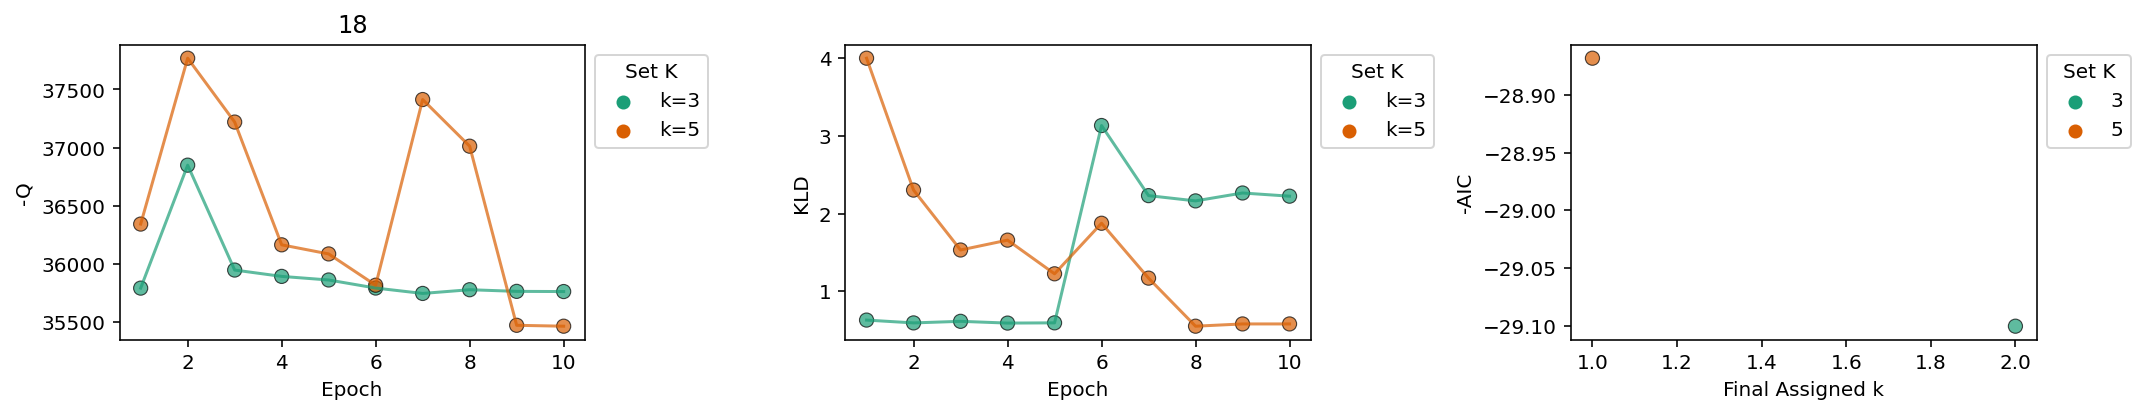

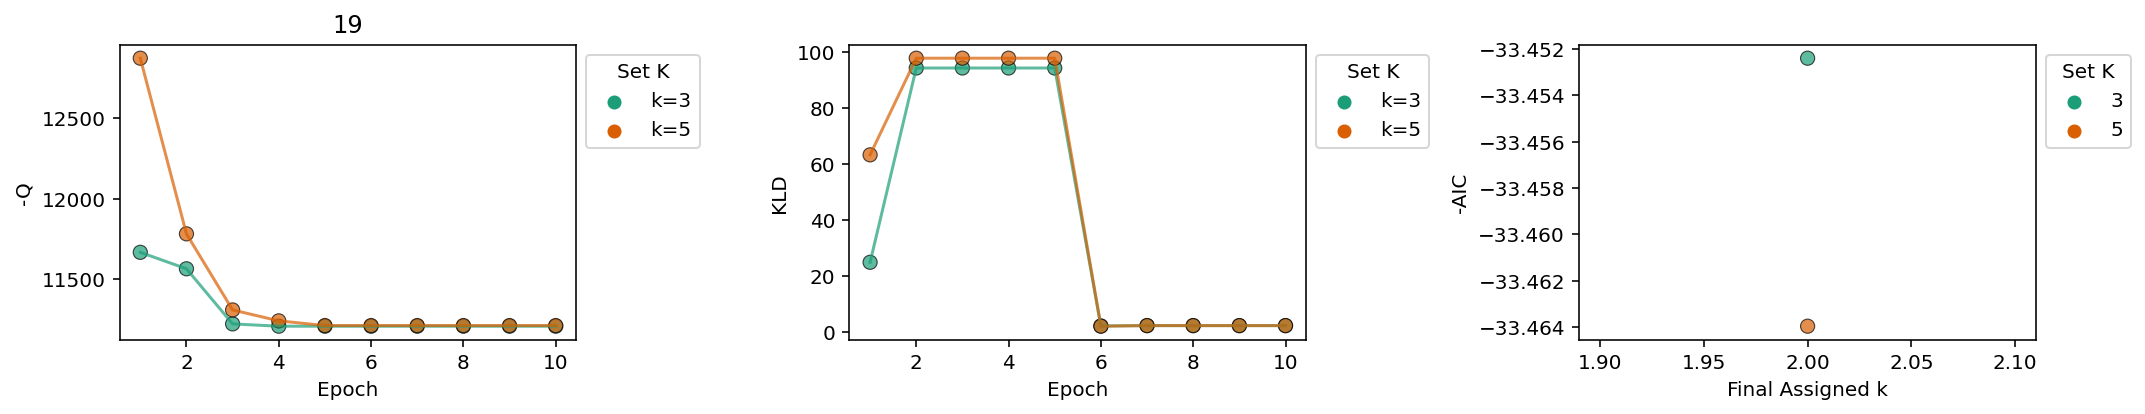

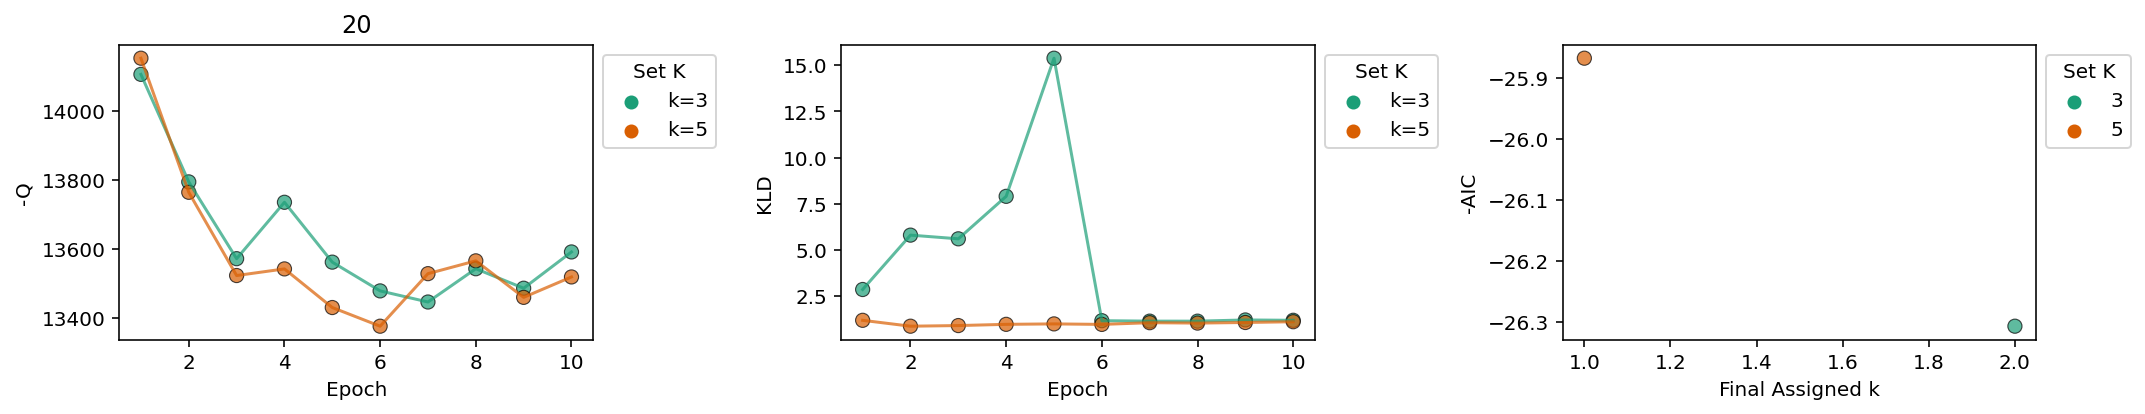

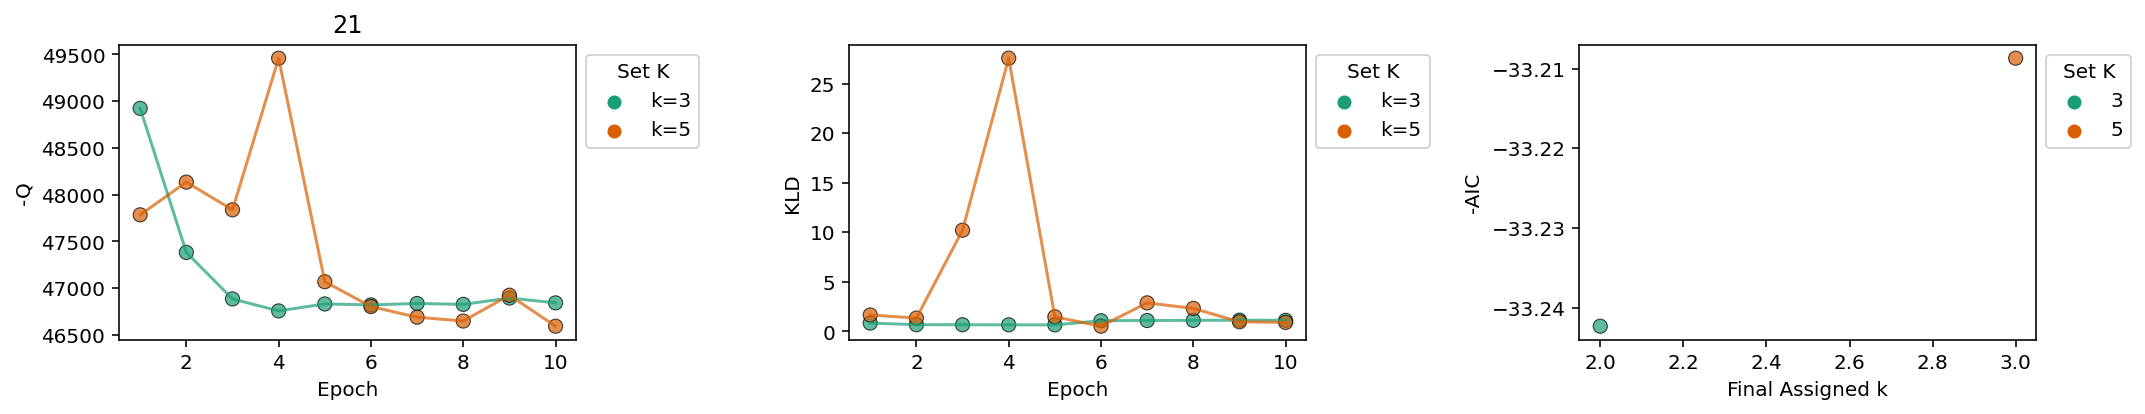

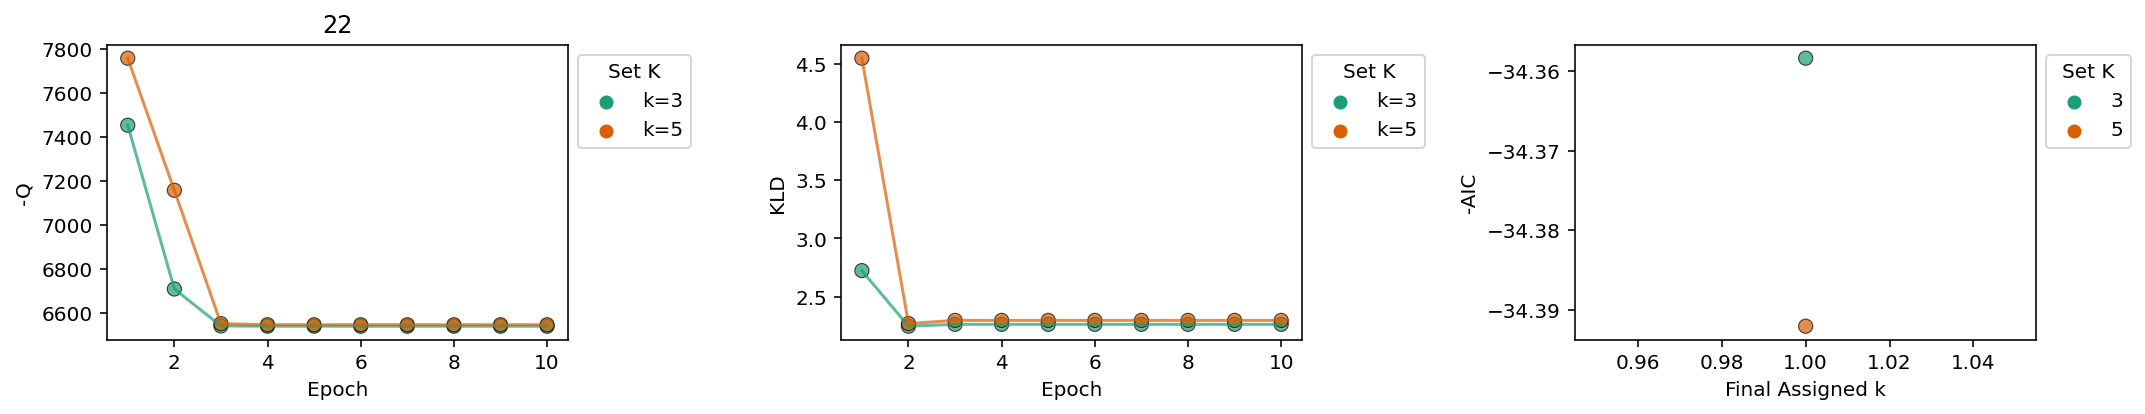

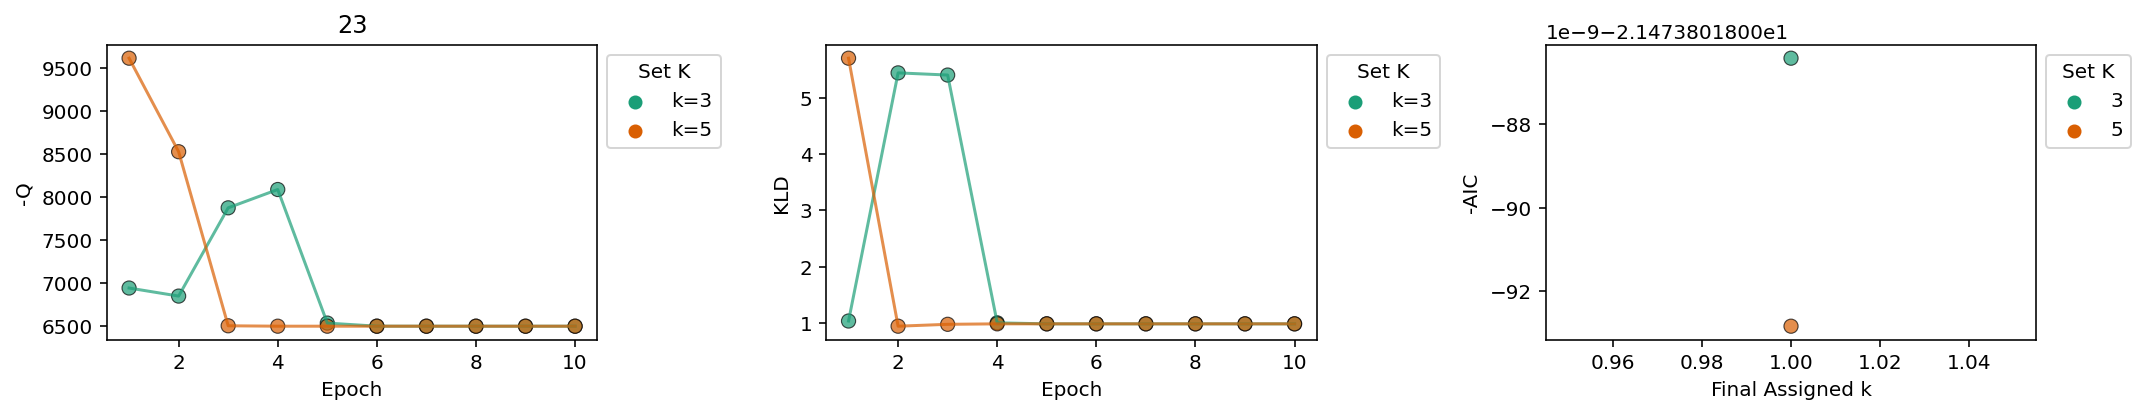

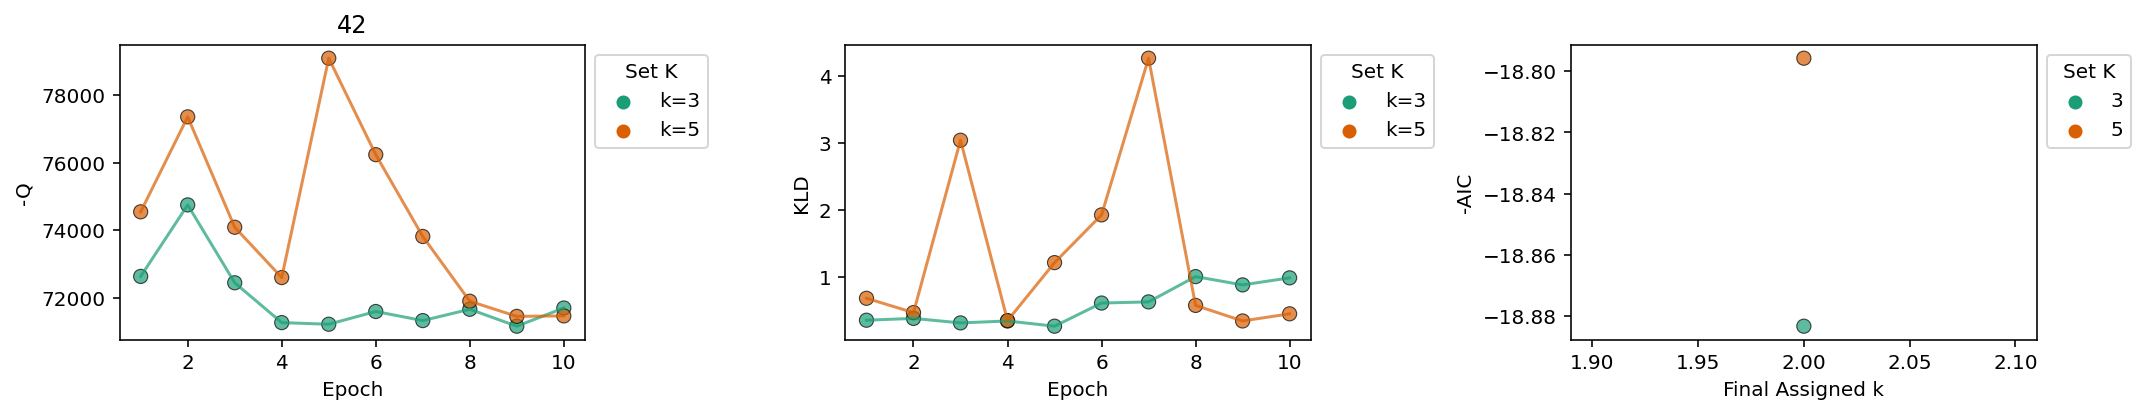

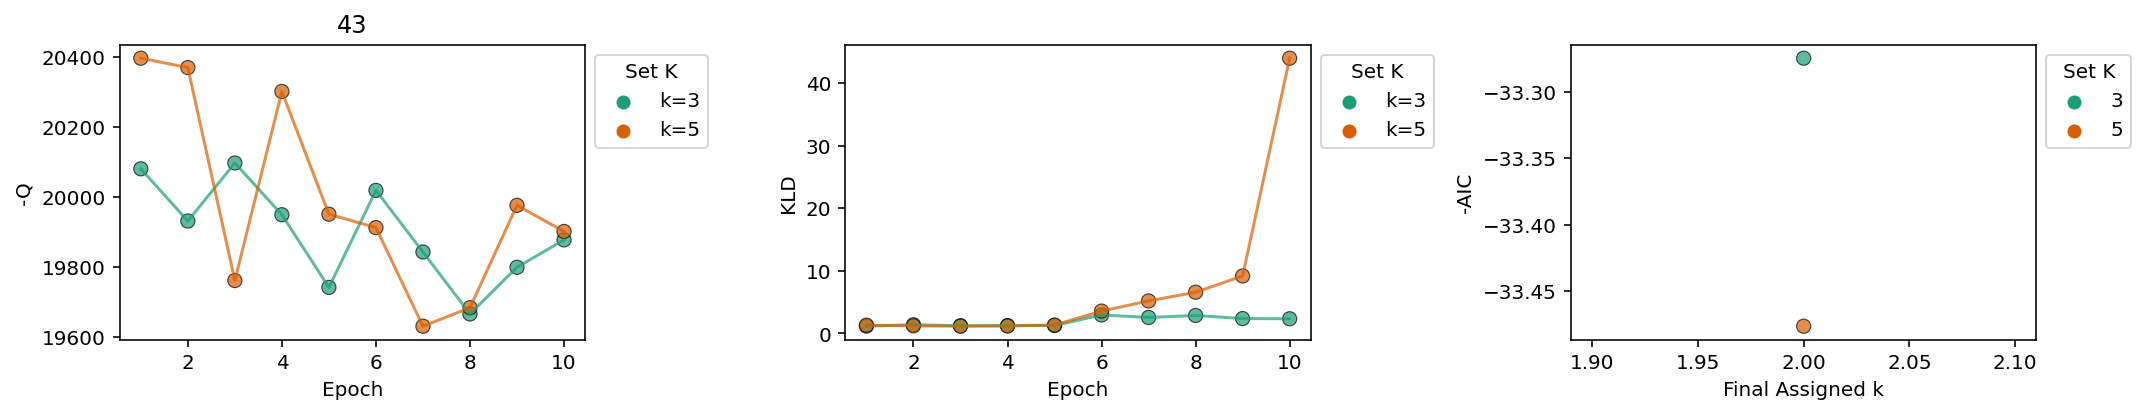

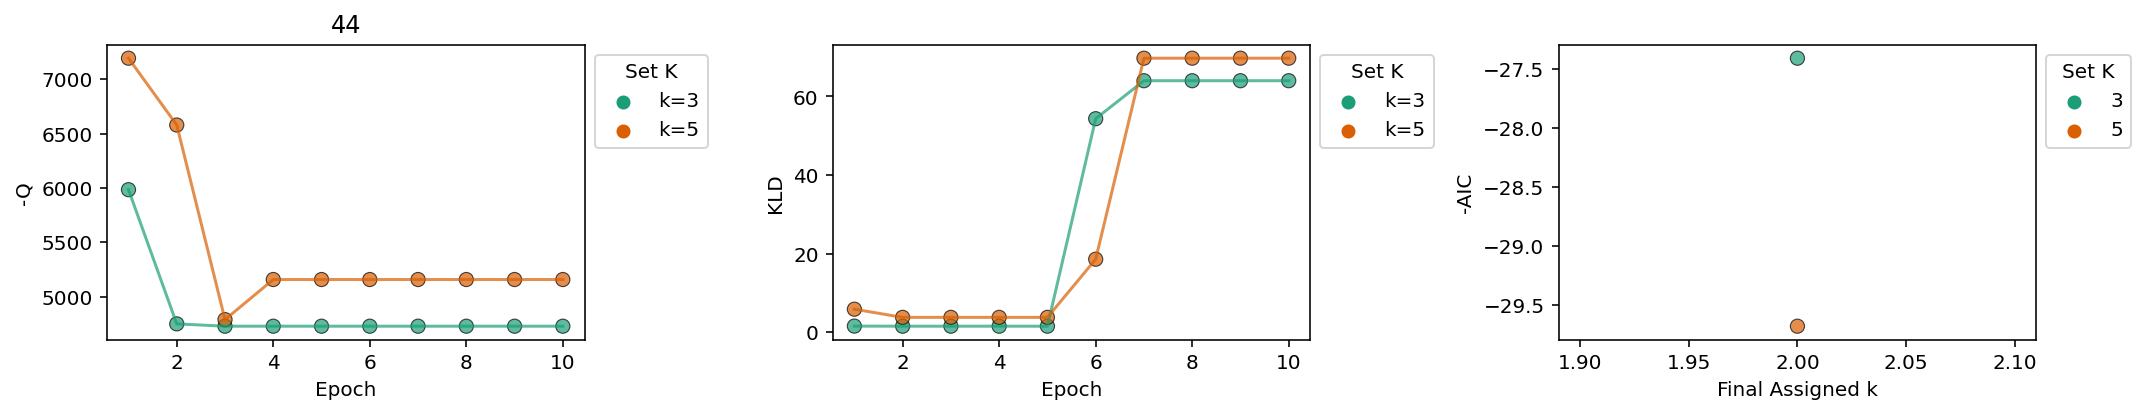

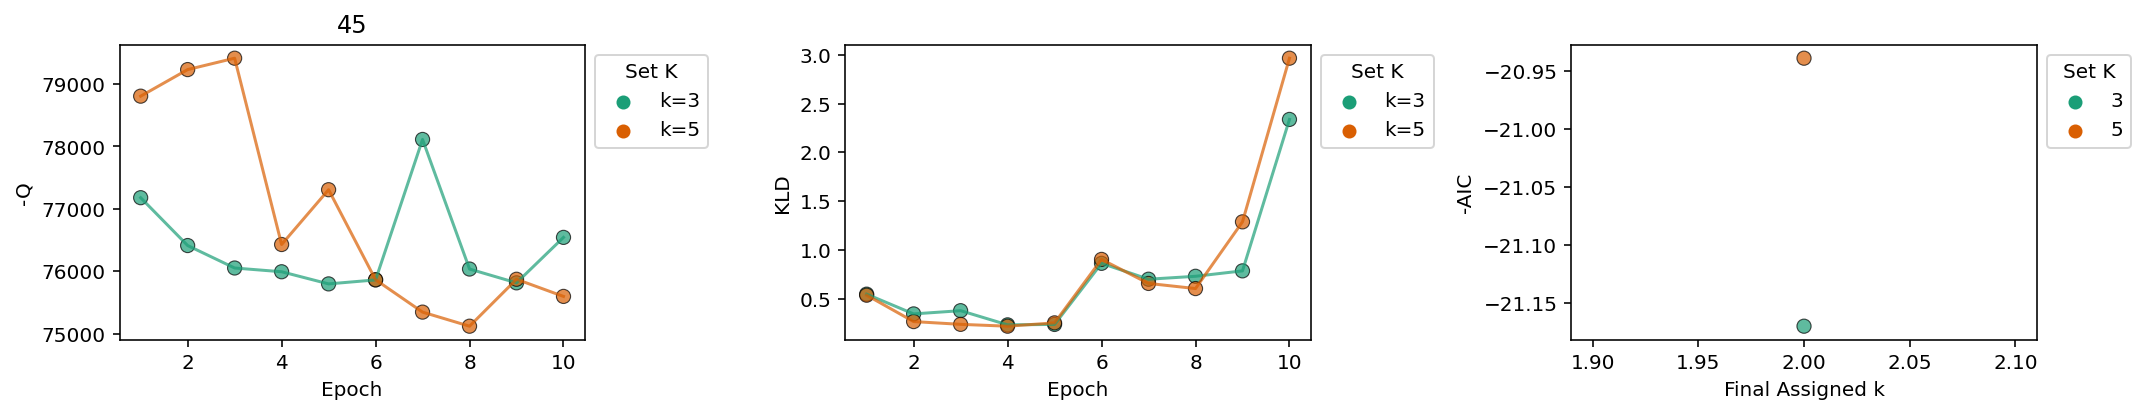

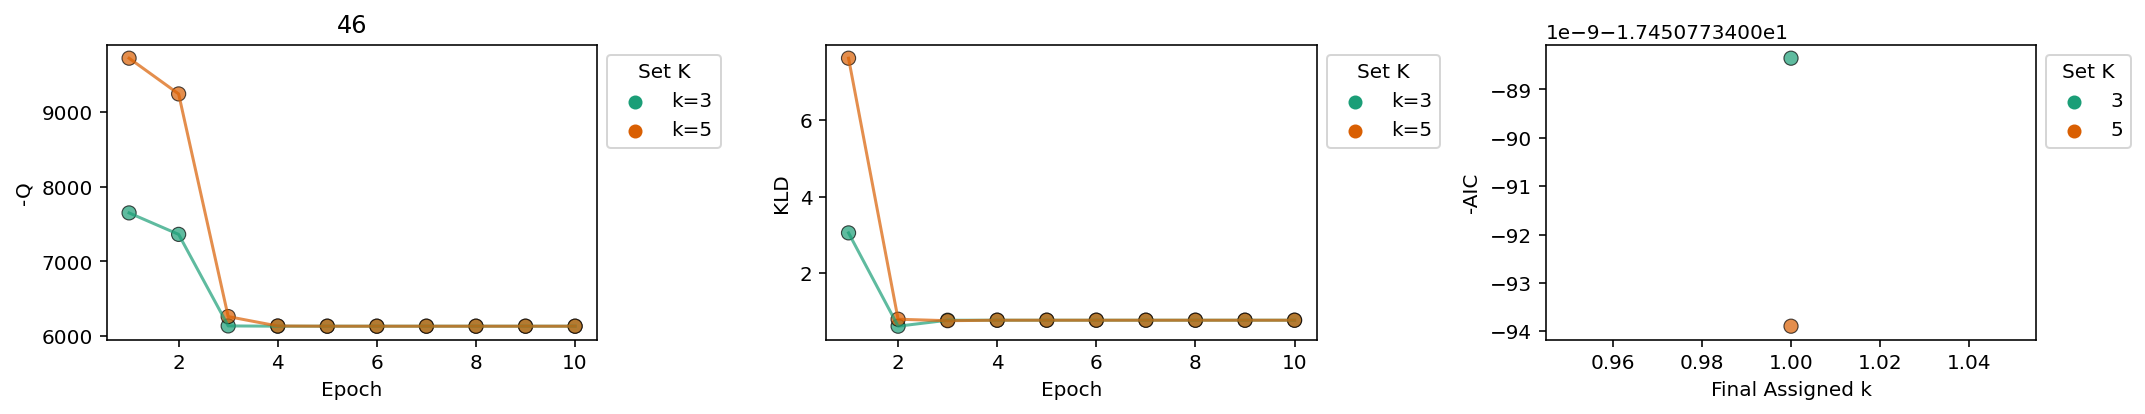

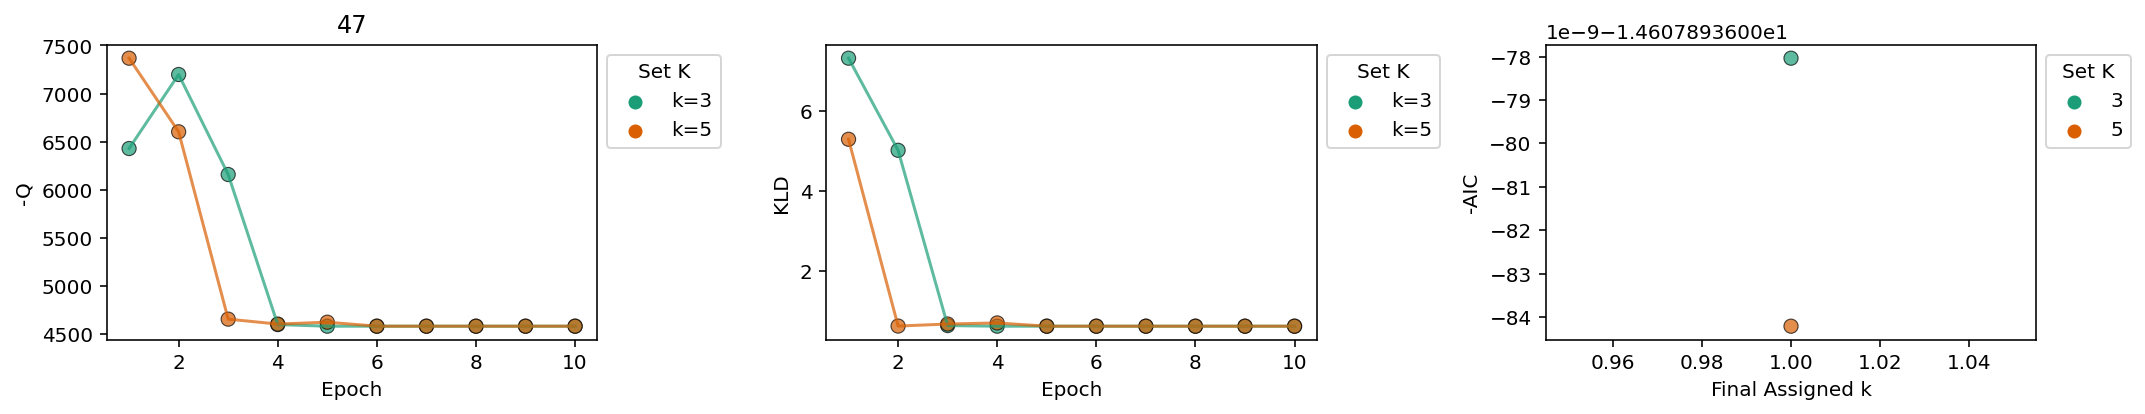

In [39]:
for s in range(0,len(sr),2):
    vis_metrics([sr[s],sr[s+1]],title=rep_conds[s],ks=Ks,figsize=(15,3))

In [40]:
conds_withpops = np.unique(rep_conds[[i for i in range(len(sr)) if len(sr[i]) > 1]])
conds_withpops

array([18, 19, 20, 21, 42, 43, 44, 45])

In [ ]:
#PLOT single/double/triple conds vs no. clusters.

In [ ]:
chosen = []

In [ ]:
#Reject gene fits and get parameter uncertainty (std error)
for i in range(len(sr_conds)):
    
    sd2 = sd_conds[i]
    
    for r in sr_conds[i]:

        fig1,ax1 = plt.subplots(1,1)
        r.find_sampling_optimum()
        #r.plot_landscape(ax1)

        fig1,ax1 = plt.subplots(1,1)
        r.plot_KL(ax1)

        r.plot_gene_distributions(sd2,marg='joint') #Rerun fits, and try uncommenting

        _=r.chisquare_testing(sd2,threshold=1e-3)
    #         r.resample_opt_viz()
    #         r.resample_opt_mc_viz()
        r.chisq_best_param_correction(sd2,Ntries=4,viz=False,threshold=1e-3) 

        r.compute_sigma(sd2,num_cores=30)
        r.plot_param_L_dep(plot_errorbars=False,plot_fit=True)
        r.plot_param_marg()

        monod.analysis.make_batch_analysis_dir([r],dir_string)
        r.update_on_disk()

In [755]:
#Read back in results
sr_arr_conds = []
for strings in sub_result_strings:
    sr_arr_conds += [[monod.analysis.load_search_results(r[:-4]+'_upd.res') for r in strings if 'upd' not in r]]
    
sr_arr_conds

[[<monod.mminference.SearchResults at 0x7f0f7ecd9d90>,

### **DE-$\theta$ Analysis of meK-Means Results**

In [ ]:
#---- What are relevant geens to look at kinetics for? (In proliferating cells, RA-treated cells, etc) ---


#asrto/diff , renewal, diff
#diff, renewal, renewal, 

#Hes5,ID2,ID4,Hes1,Notch1,Sox9, 

#Self-renew: Notch1,ID4,

#Kif2c NSC marker: https://www.sciencedirect.com/science/article/pii/S0378111918310084

#Proliferation: # Nusap1, Top2a, Cdca8, and Mki67 https://www.sciencedirect.com/science/article/pii/S2211124717318132?via%3Dihub


#Switch to Diff --> Cux1,Cux2,Emx2

#Vim,

#Activated --> Ascl1,Egfr,Dlx2, 

#Astro diff: Olig1, Olig2, Sox9, Gfap,
#Astro: Slc1a2, Glul
#Oligo Diff: Pdgfa, Sox10

#Mitosis:Prc1, Cenpf, Ube2c, Cdc20




# 0 vs 1

# 0: Less Top2a, Znf3,Lrp4, Klf13     Idh1 (less burs less deg Gpm6b) Less Flot1, more deg NUSAP1
# 1: More Pan3

# https://stemcellres.biomedcentral.com/articles/10.1186/s13287-018-0862-9 

# 0 vs 2

# 0: Less Top2a, Less Lrp4,Klf13  more deg Birc6 --> prevents apoptosis (less burs less deg Gpm6b)
# 2: More Pan3




# 1 vs 2

# 1: more Arl6ip1, ,Nusap1 --> Mitosis    more burst + deg Birc6   less deg Gpm6b (more juvenile) Rorb (less burst, less deg)
# less deg Mlc1 (astro), Zeb1  + Cdca8 expression up (prolif) + Cdc20 --> mitosis


# 0: man more Psap/quiescence, DR6 neuron death

# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8856713/

# ------------------------------------------------------------------------------------------

# Look for proliferation/retinoic acid related genes (not differentiation genes necessarily) 

# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3837441/   (RA +NSCs)


# 0 vs 1 different states of proliferation (Nusap1, Top2a + Cdca8+Mki67,CDC20 in Spliced  + RAstim genes like Gap43,Map2,Cdc42,Hes5(differential)
# 1 vs 2:  Nusap1 still, Gsk3b (inhibit --> proliferation https://pubmed.ncbi.nlm.nih.gov/22642687/) , less deg Zeb1 which --> renewal, no diff (https://www.sciencedirect.com/science/article/pii/S2211124719305613) + Birc6 maybe (knockdown can cell cycle arrest)

# 0: ID2 spliced expression, from RA effect https://pubmed.ncbi.nlm.nih.gov/15744343/ + ID2/HES5 S expression show OPC like https://link.springer.com/article/10.1007/s10571-022-01313-5
